In [1]:
# ============================================================================
# Cell 1: Setup
# ============================================================================
import sys
import os
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from src.utils.config_loader import ConfigLoader
from src.models import LeNet5
from src.data.dataset import ChestXrayDataset
from src.training.trainer import Trainer

print("✅ Imports successful!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

✅ Imports successful!
PyTorch: 2.8.0+cu129
CUDA: True


In [2]:
# ============================================================================
# Cell 2: Load configs
# ============================================================================
loader = ConfigLoader(project_root)

model_config = loader.load_model_config('lenet')
data_config = loader.load_data_config()

print("=" * 70)
print("📋 CONFIGURATION")
print("=" * 70)
print(f"\nModel: {model_config['model']['name']}")
print(f"  Type: {model_config['model']['type']}")
print(f"  Description: {model_config['model']['description']}")

print(f"\nTraining:")
print(f"  Epochs: {model_config['training']['num_epochs']}")
print(f"  Batch Size: {model_config['training']['batch_size']}")
print(f"  Learning Rate: {model_config['training']['learning_rate']}")

print(f"\nData:")
print(f"  Root: {data_config['data']['root_dir']}")
print(f"  Workers: {model_config['data']['num_workers']}")
print(f"  Prefetch: {model_config['data']['prefetch_factor']}")

print(f"\nDevice: {model_config['device']}")
print("=" * 70)

📋 CONFIGURATION

Model: LeNet-5
  Type: lenet
  Description: Classic CNN architecture (1998)

Training:
  Epochs: 30
  Batch Size: 64
  Learning Rate: 0.001

Data:
  Root: /home/ducluong/chest-xray-classification/data/balanced
  Workers: 4
  Prefetch: 2

Device: cuda


In [3]:
# ============================================================================
# Cell 3: Prepare transforms
# ============================================================================
norm_type = model_config['data']['normalization']
mean = data_config['data']['normalization'][norm_type]['mean']
std = data_config['data']['normalization'][norm_type]['std']
image_size = data_config['data']['image_size']

print(f"Image size: {image_size}x{image_size}")
print(f"Normalization: {norm_type}")
print(f"  Mean: {mean}")
print(f"  Std:  {std}")

# Training transforms
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(data_config['data']['augmentation']['rotation_degrees']),
    transforms.ColorJitter(
        brightness=data_config['data']['augmentation']['color_jitter']['brightness'],
        contrast=data_config['data']['augmentation']['color_jitter']['contrast']
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms
val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

print("✅ Transforms created")

Image size: 224x224
Normalization: imagenet
  Mean: [0.485, 0.456, 0.406]
  Std:  [0.229, 0.224, 0.225]
✅ Transforms created


In [4]:
# ============================================================================
# Cell 4: Create datasets from BALANCED data
# ============================================================================
# Force use balanced data
DATA_ROOT = data_config['data']['root_dir']

print(f"\n📂 Loading data from: {DATA_ROOT}")

train_dataset = ChestXrayDataset(
    root_dir=os.path.join(DATA_ROOT, 'train'),
    transform=train_transform
)

val_dataset = ChestXrayDataset(
    root_dir=os.path.join(DATA_ROOT, 'val'),
    transform=val_transform
)

print(f"\n✅ Datasets loaded:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val:   {len(val_dataset):,} samples")

# Show distribution
print(f"\n📊 Train Distribution:")
train_dist = train_dataset.get_class_distribution()
total = sum(train_dist.values())
for cls, count in sorted(train_dist.items()):
    pct = (count / total) * 100
    print(f"  {cls:20s}: {count:5d} ({pct:5.2f}%)")

# Check balance
counts = list(train_dist.values())
balance_ratio = min(counts) / max(counts)
print(f"\n  Balance ratio: {balance_ratio:.3f} ", end="")
if balance_ratio >= 0.9:
    print("✅ Well balanced!")
elif balance_ratio >= 0.7:
    print("⚠️  Moderately balanced")
else:
    print("❌ IMBALANCED - Run 02b_balance_data.ipynb!")
    raise ValueError("Data not balanced!")


📂 Loading data from: /home/ducluong/chest-xray-classification/data/balanced
📂 Detected classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
✅ Loaded 10000 images from /home/ducluong/chest-xray-classification/data/balanced/train
📂 Detected classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
✅ Loaded 2500 images from /home/ducluong/chest-xray-classification/data/balanced/val

✅ Datasets loaded:
  Train: 10,000 samples
  Val:   2,500 samples

📊 Train Distribution:
  COVID-19            :  2500 (25.00%)
  Normal              :  2500 (25.00%)
  Pneumonia           :  2500 (25.00%)
  Tuberculosis        :  2500 (25.00%)

  Balance ratio: 1.000 ✅ Well balanced!


In [5]:
# ============================================================================
# Cell 5: Create dataloaders
# ============================================================================
train_loader = DataLoader(
    train_dataset,
    batch_size=model_config['training']['batch_size'],
    shuffle=True,
    num_workers=model_config['data']['num_workers'],
    pin_memory=model_config['data']['pin_memory'],
    prefetch_factor=model_config['data']['prefetch_factor'],
    persistent_workers=model_config['data']['persistent_workers']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=model_config['training']['batch_size'],
    shuffle=False,
    num_workers=model_config['data']['num_workers'],
    pin_memory=model_config['data']['pin_memory'],
    prefetch_factor=model_config['data']['prefetch_factor'],
    persistent_workers=model_config['data']['persistent_workers']
)

print(f"✅ DataLoaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val:   {len(val_loader)} batches")
print(f"  Batch size: {model_config['training']['batch_size']}")

✅ DataLoaders created:
  Train: 157 batches
  Val:   40 batches
  Batch size: 64


In [6]:
# ============================================================================
# Cell 6: Create model
# ============================================================================
device = torch.device(model_config['device']) if torch.cuda.is_available() else torch.device('cpu')

model = LeNet5(num_classes=model_config['model']['num_classes'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=model_config['training']['learning_rate'],
    weight_decay=model_config['training']['weight_decay'],
    betas=tuple(model_config['training']['optimizer']['betas'])
)

print("=" * 70)
print("🤖 MODEL SETUP")
print("=" * 70)
print(f"Model: {model_config['model']['name']}")
print(f"Device: {device}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {total_params:,}")
print(f"Model size: ~{total_params * 4 / 1024**2:.1f} MB")

print(f"\nLoss: {criterion.__class__.__name__}")
print(f"Optimizer: {model_config['training']['optimizer']['type']}")
print(f"  LR: {model_config['training']['learning_rate']}")
print(f"  Weight decay: {model_config['training']['weight_decay']}")
print("=" * 70)

🤖 MODEL SETUP
Model: LeNet-5
Device: cuda
Parameters: 5,612,216
Model size: ~21.4 MB

Loss: CrossEntropyLoss
Optimizer: Adam
  LR: 0.001
  Weight decay: 0.0001


In [7]:
# ============================================================================
# Cell 7: GPU Memory Check & Cleanup
# ============================================================================
import gc

print("\n" + "=" * 70)
print("🔍 GPU MEMORY CHECK")
print("=" * 70)

if torch.cuda.is_available():
    # Clear cache
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    # Get memory info
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    allocated = torch.cuda.memory_allocated(0) / 1024**2
    reserved = torch.cuda.memory_reserved(0) / 1024**2
    
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {total_mem:.1f} GB")
    print(f"Allocated: {allocated:.1f} MB")
    print(f"Reserved: {reserved:.1f} MB")
    print(f"Free: {(total_mem * 1024) - reserved:.0f} MB")
    
    # Test batch allocation
    print(f"\n🧪 Testing batch allocation...")
    try:
        test_batch = torch.randn(
            model_config['training']['batch_size'], 
            3, image_size, image_size
        ).to(device)
        
        model_test = model.to(device)
        with torch.no_grad():
            _ = model_test(test_batch)
        
        peak = torch.cuda.max_memory_allocated(0) / 1024**2
        
        print(f"  ✅ Peak usage: {peak:.1f} MB")
        print(f"  ✅ Per batch: ~{peak:.1f} MB")
        
        # Estimate total for training
        estimated_total = peak * 1.5  # Safety margin
        print(f"  ✅ Estimated total: ~{estimated_total:.0f} MB")
        
        if estimated_total > (total_mem * 1024 * 0.8):
            print(f"\n  ⚠️  WARNING: May use >{estimated_total/1024:.1f} GB")
            print(f"     Consider reducing batch_size")
        else:
            print(f"\n  ✅ Memory sufficient ({estimated_total/1024:.1f} GB / {total_mem:.1f} GB)")
        
        # Cleanup
        del test_batch, model_test
        torch.cuda.empty_cache()
        
    except RuntimeError as e:
        print(f"  ❌ Memory test FAILED!")
        print(f"     {e}")
        print(f"\n🔧 SOLUTION: Reduce batch_size in lenet_config.yaml")
        raise
else:
    print("CPU mode - no memory check needed")

print("=" * 70)


🔍 GPU MEMORY CHECK
GPU: NVIDIA GeForce RTX 5070 Ti
Total VRAM: 15.9 GB
Allocated: 0.0 MB
Reserved: 0.0 MB
Free: 16303 MB

🧪 Testing batch allocation...
  ✅ Peak usage: 206.8 MB
  ✅ Per batch: ~206.8 MB
  ✅ Estimated total: ~310 MB

  ✅ Memory sufficient (0.3 GB / 15.9 GB)


In [8]:
# ============================================================================
# Cell 8: Train
# ============================================================================
import time

print("\n" + "=" * 70)
print("🚀 STARTING TRAINING")
print("=" * 70)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    checkpoint_dir=model_config['checkpoint']['save_dir']
)

start_time = time.time()

history = trainer.train(
    num_epochs=model_config['training']['num_epochs'],
    save_best=model_config['checkpoint']['save_best']
)

elapsed_time = time.time() - start_time

print("\n" + "=" * 70)
print("✅ TRAINING COMPLETED")
print("=" * 70)
print(f"⏱️  Total time: {elapsed_time/60:.1f} minutes ({elapsed_time/3600:.2f} hours)")
print(f"⏱️  Time per epoch: {elapsed_time/model_config['training']['num_epochs']:.1f} seconds")
print(f"📊 Best val accuracy: {max(history['val_acc']):.2f}%")
print("=" * 70)

# Rename checkpoint
import shutil
old_path = os.path.join(model_config['checkpoint']['save_dir'], 'best_model.pth')
new_path = os.path.join(model_config['checkpoint']['save_dir'], 
                        f"{model_config['model']['type']}_best.pth")
if os.path.exists(old_path):
    shutil.move(old_path, new_path)
    print(f"✅ Checkpoint saved: {new_path}")


🚀 STARTING TRAINING
Training on cuda
Total epochs: 30

Epoch 1/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s, loss=0.425, acc=84.3]



Train Loss: 0.6539 | Train Acc: 73.14%
Val Loss: 0.4248 | Val Acc: 84.28%
✅ Saved best model! (Val Acc: 84.28%)

Epoch 2/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.55it/s, loss=0.3, acc=89.5]  



Train Loss: 0.3823 | Train Acc: 85.40%
Val Loss: 0.2995 | Val Acc: 89.48%
✅ Saved best model! (Val Acc: 89.48%)

Epoch 3/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s, loss=0.288, acc=89.8]



Train Loss: 0.3017 | Train Acc: 88.60%
Val Loss: 0.2883 | Val Acc: 89.76%
✅ Saved best model! (Val Acc: 89.76%)

Epoch 4/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s, loss=0.306, acc=89]  



Train Loss: 0.2631 | Train Acc: 90.16%
Val Loss: 0.3057 | Val Acc: 88.96%

Epoch 5/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, loss=0.274, acc=90.9]   



Train Loss: 0.2230 | Train Acc: 91.82%
Val Loss: 0.2738 | Val Acc: 90.92%
✅ Saved best model! (Val Acc: 90.92%)

Epoch 6/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, loss=0.301, acc=90.1]



Train Loss: 0.2168 | Train Acc: 92.11%
Val Loss: 0.3005 | Val Acc: 90.08%

Epoch 7/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.53it/s, loss=0.275, acc=89.8]



Train Loss: 0.2000 | Train Acc: 92.57%
Val Loss: 0.2745 | Val Acc: 89.80%

Epoch 8/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s, loss=0.264, acc=91.8]   



Train Loss: 0.1831 | Train Acc: 93.15%
Val Loss: 0.2644 | Val Acc: 91.80%
✅ Saved best model! (Val Acc: 91.80%)

Epoch 9/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s, loss=0.32, acc=89.4] 



Train Loss: 0.1681 | Train Acc: 93.82%
Val Loss: 0.3202 | Val Acc: 89.44%

Epoch 10/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s, loss=0.251, acc=92.2]



Train Loss: 0.1595 | Train Acc: 94.20%
Val Loss: 0.2510 | Val Acc: 92.16%
✅ Saved best model! (Val Acc: 92.16%)

Epoch 11/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.48it/s, loss=0.257, acc=92.3]   



Train Loss: 0.1568 | Train Acc: 94.36%
Val Loss: 0.2568 | Val Acc: 92.32%
✅ Saved best model! (Val Acc: 92.32%)

Epoch 12/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, loss=0.282, acc=92]  



Train Loss: 0.1432 | Train Acc: 94.57%
Val Loss: 0.2817 | Val Acc: 91.96%

Epoch 13/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.51it/s, loss=0.305, acc=90.6]



Train Loss: 0.1425 | Train Acc: 94.75%
Val Loss: 0.3047 | Val Acc: 90.60%

Epoch 14/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.56it/s, loss=0.334, acc=89.7]



Train Loss: 0.1310 | Train Acc: 95.31%
Val Loss: 0.3342 | Val Acc: 89.68%

Epoch 15/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, loss=0.222, acc=93.1]



Train Loss: 0.1382 | Train Acc: 94.85%
Val Loss: 0.2219 | Val Acc: 93.12%
✅ Saved best model! (Val Acc: 93.12%)

Epoch 16/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s, loss=0.235, acc=93.2]



Train Loss: 0.1265 | Train Acc: 95.55%
Val Loss: 0.2353 | Val Acc: 93.20%
✅ Saved best model! (Val Acc: 93.20%)

Epoch 17/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s, loss=0.291, acc=92]  



Train Loss: 0.1170 | Train Acc: 95.87%
Val Loss: 0.2911 | Val Acc: 91.96%

Epoch 18/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s, loss=0.236, acc=92.3]   



Train Loss: 0.1179 | Train Acc: 95.72%
Val Loss: 0.2357 | Val Acc: 92.28%

Epoch 19/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s, loss=0.28, acc=90.7] 



Train Loss: 0.1174 | Train Acc: 95.57%
Val Loss: 0.2804 | Val Acc: 90.72%

Epoch 20/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s, loss=0.222, acc=92]  



Train Loss: 0.1007 | Train Acc: 96.53%
Val Loss: 0.2221 | Val Acc: 91.96%

Epoch 21/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, loss=0.293, acc=92.2]



Train Loss: 0.1111 | Train Acc: 96.10%
Val Loss: 0.2927 | Val Acc: 92.20%

Epoch 22/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.49it/s, loss=0.335, acc=90.6]



Train Loss: 0.1136 | Train Acc: 95.79%
Val Loss: 0.3346 | Val Acc: 90.64%

Epoch 23/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.57it/s, loss=0.272, acc=93.4]



Train Loss: 0.1028 | Train Acc: 96.16%
Val Loss: 0.2718 | Val Acc: 93.40%
✅ Saved best model! (Val Acc: 93.40%)

Epoch 24/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s, loss=0.24, acc=93.5] 



Train Loss: 0.0918 | Train Acc: 96.61%
Val Loss: 0.2402 | Val Acc: 93.48%
✅ Saved best model! (Val Acc: 93.48%)

Epoch 25/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:16<00:00,  2.49it/s, loss=0.294, acc=93]  



Train Loss: 0.0949 | Train Acc: 96.88%
Val Loss: 0.2941 | Val Acc: 92.96%

Epoch 26/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s, loss=0.278, acc=93.6]



Train Loss: 0.0938 | Train Acc: 96.60%
Val Loss: 0.2783 | Val Acc: 93.60%
✅ Saved best model! (Val Acc: 93.60%)

Epoch 27/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, loss=0.348, acc=92.4]



Train Loss: 0.0876 | Train Acc: 96.81%
Val Loss: 0.3480 | Val Acc: 92.40%

Epoch 28/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, loss=0.384, acc=92.4]



Train Loss: 0.0842 | Train Acc: 97.05%
Val Loss: 0.3839 | Val Acc: 92.36%

Epoch 29/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.58it/s, loss=0.317, acc=92.6]



Train Loss: 0.0758 | Train Acc: 97.51%
Val Loss: 0.3167 | Val Acc: 92.60%

Epoch 30/30
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:15<00:00,  2.57it/s, loss=0.269, acc=92.7]



Train Loss: 0.0912 | Train Acc: 96.91%
Val Loss: 0.2689 | Val Acc: 92.72%

Training completed!
Best validation accuracy: 93.60%

✅ TRAINING COMPLETED
⏱️  Total time: 36.9 minutes (0.61 hours)
⏱️  Time per epoch: 73.7 seconds
📊 Best val accuracy: 93.60%
✅ Checkpoint saved: /home/ducluong/chest-xray-classification/checkpoints/lenet_best.pth


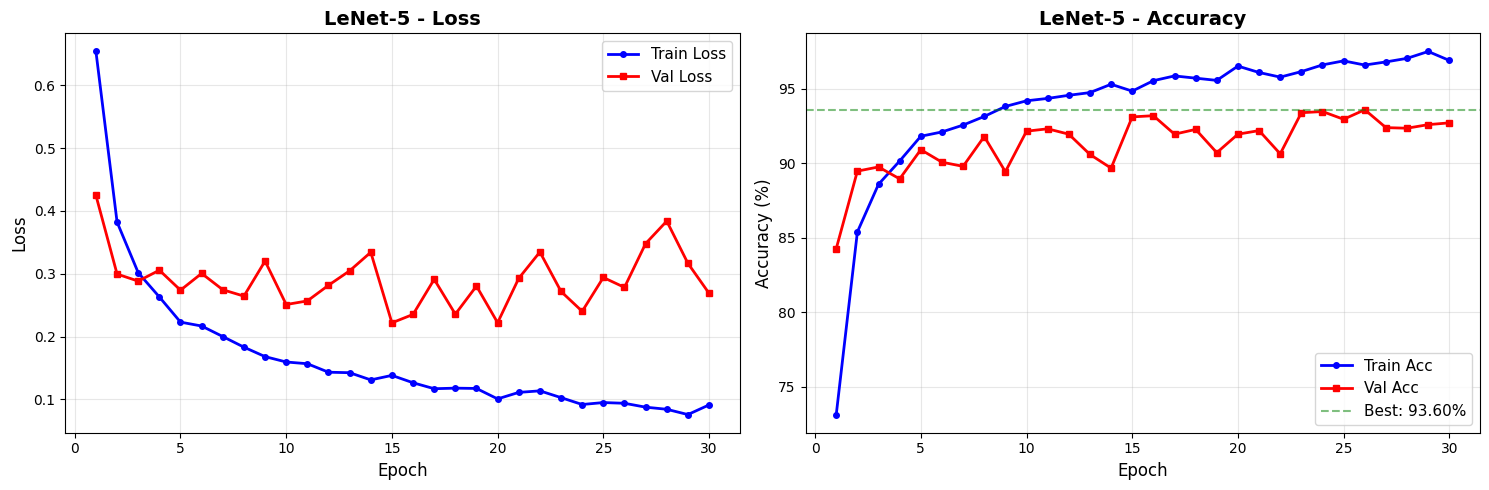

✅ Plot saved: ../results/figures/lenet_training.png


In [9]:
# ============================================================================
# Cell 9: Visualize results
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss plot
axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=4)
axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=4)
axes[0].set_title(f"{model_config['model']['name']} - Loss", fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=4)
axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=4)
axes[1].set_title(f"{model_config['model']['name']} - Accuracy", fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Add best val acc annotation
best_epoch = np.argmax(history['val_acc']) + 1
best_acc = max(history['val_acc'])
axes[1].axhline(y=best_acc, color='g', linestyle='--', alpha=0.5, label=f'Best: {best_acc:.2f}%')
axes[1].legend(fontsize=11)

plt.tight_layout()

# Save
save_path = f"../results/figures/{model_config['model']['type']}_training.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved: {save_path}")

In [10]:
# ============================================================================
# Cell 10: Training summary
# ============================================================================
print("\n" + "=" * 70)
print("📊 TRAINING SUMMARY")
print("=" * 70)

print(f"\n🏆 Best Performance:")
print(f"  Best Val Accuracy: {max(history['val_acc']):.2f}%")
print(f"  At Epoch: {np.argmax(history['val_acc']) + 1}")
print(f"  Final Train Acc: {history['train_acc'][-1]:.2f}%")
print(f"  Final Val Acc: {history['val_acc'][-1]:.2f}%")

print(f"\n📉 Loss:")
print(f"  Initial Train Loss: {history['train_loss'][0]:.4f}")
print(f"  Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Initial Val Loss: {history['val_loss'][0]:.4f}")
print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")

print(f"\n⏱️  Time:")
print(f"  Total: {elapsed_time/60:.1f} minutes")
print(f"  Per Epoch: {elapsed_time/model_config['training']['num_epochs']:.1f} seconds")

print(f"\n💾 Saved:")
print(f"  Checkpoint: {new_path}")
print(f"  Plot: {save_path}")

print("\n" + "=" * 70)
print("🎯 Next Steps:")
print("  1. Run evaluation notebook to test on test set")
print("  2. Train other models (ResNet, DenseNet, ViT)")
print("  3. Compare all models")
print("=" * 70)

# Cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


📊 TRAINING SUMMARY

🏆 Best Performance:
  Best Val Accuracy: 93.60%
  At Epoch: 26
  Final Train Acc: 96.91%
  Final Val Acc: 92.72%

📉 Loss:
  Initial Train Loss: 0.6539
  Final Train Loss: 0.0912
  Initial Val Loss: 0.4248
  Final Val Loss: 0.2689

⏱️  Time:
  Total: 36.9 minutes
  Per Epoch: 73.7 seconds

💾 Saved:
  Checkpoint: /home/ducluong/chest-xray-classification/checkpoints/lenet_best.pth
  Plot: ../results/figures/lenet_training.png

🎯 Next Steps:
  1. Run evaluation notebook to test on test set
  2. Train other models (ResNet, DenseNet, ViT)
  3. Compare all models
